# Brain Tumor Classification

**data(kaggle) : (https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)**

Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms               # 데이터 전처리 및 증강 
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Get Data

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder('/home/minyoungxi/MINYOUNGXI/Medical/braintumor/data/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/home/minyoungxi/MINYOUNGXI/Medical/braintumor/data/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

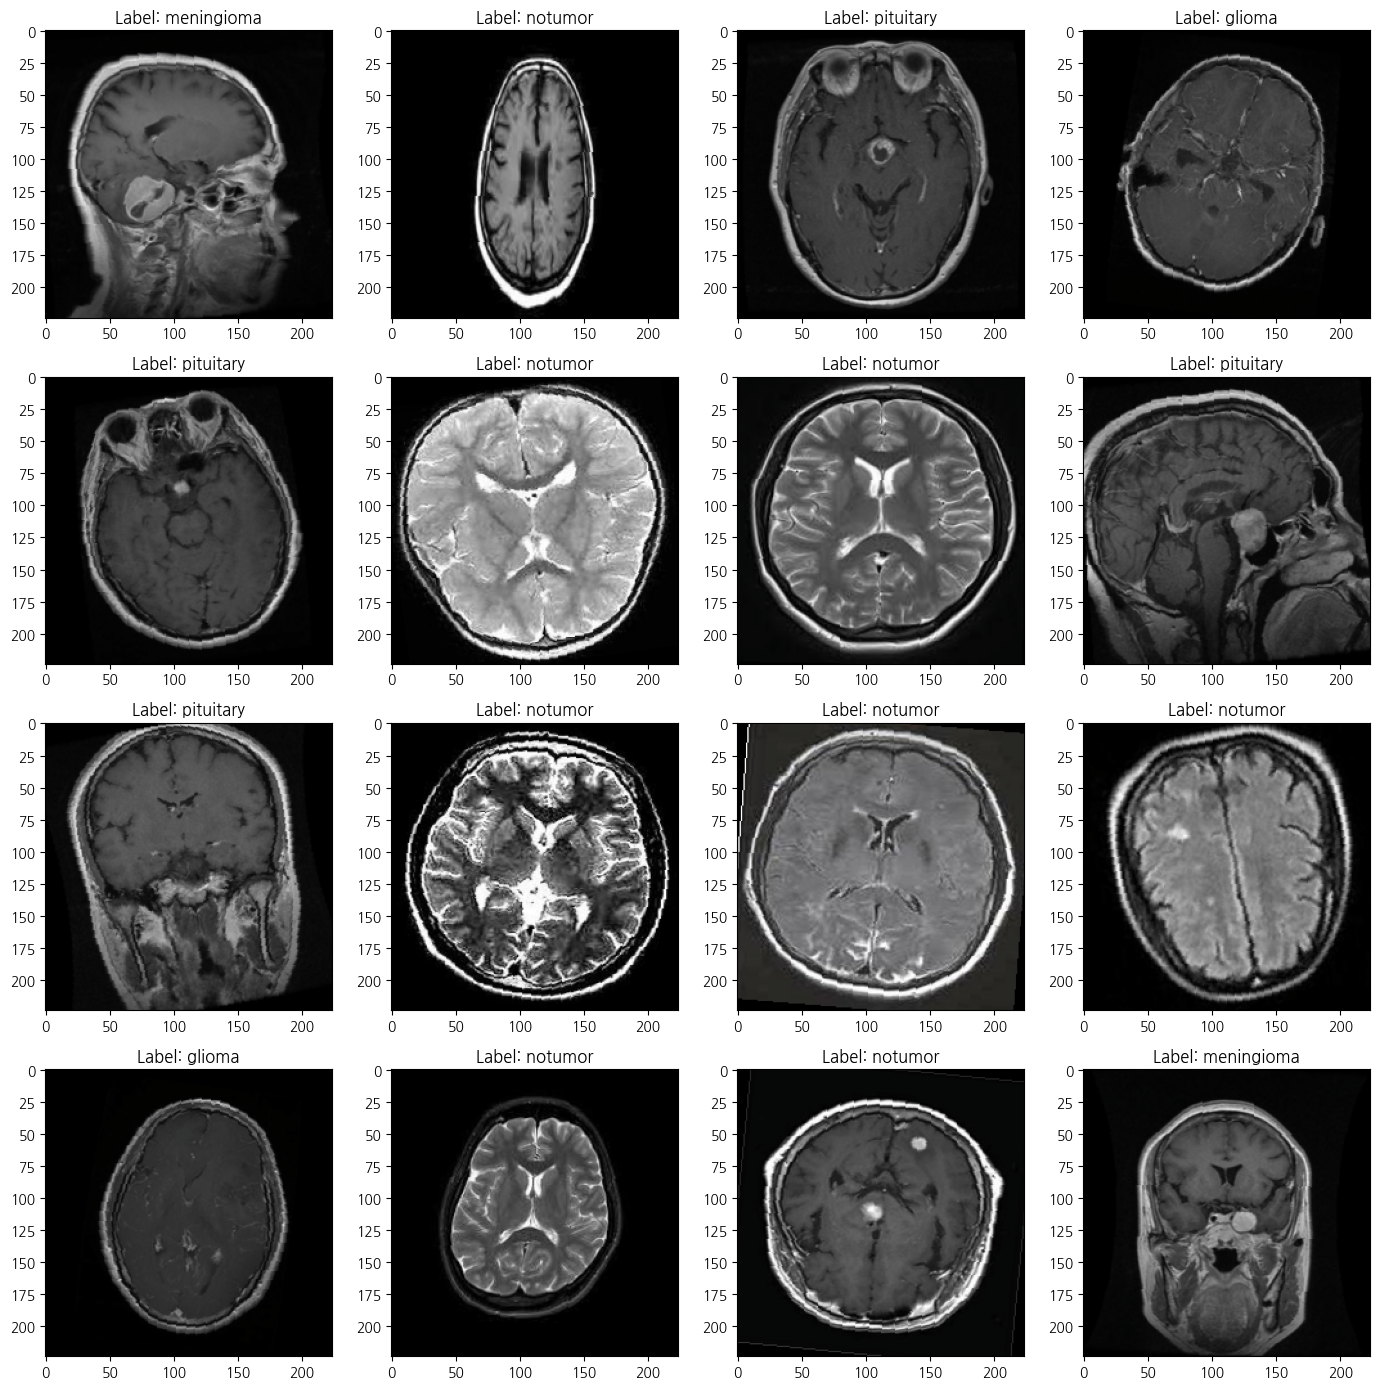

In [4]:
data_iter = iter(train_loader)   # iter() 함수로 이터레이터 생성 next() 함수로 다음 배치의 이미지와 레이블을 가져옴
images, labels = next(data_iter)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1) 
# transpose(0,2,3,1)로 채널의 순서를 파이토치의 (배치크기, 채널, 높이, 너비)에서 Matplotlib에서 사용하는 (배치크기, 높이, 너비, 채널)fh qusrud
# 이후 std와 mean을 이요해 정규화를 역으로 수행하고 clip(0,1)으로 모든 픽셀 값을 0~1 범위로 제한

num_images = len(images) # 시각화 하려는 이미지의 총 개수 
rows = int(np.ceil(num_images/4)) # ceil() 함수로 값을 올림하여 반환
fig, axes = plt.subplots(rows, 4, figsize=(14, 14))     

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [5]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential( # 이미지에서 특징을 추출하기 위한 컨볼루션 레이어와 풀링 레이어
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 3개의 입력 채널, 16개의 출력 채널, 3x3 커널, 1만큼의 패딩
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 2x2 윈도우에 대해 맥스 풀링을 수행하고 2만큼의 스트라이드
            nn.Conv2d(16, 32, kernel_size=3, padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential( # 추출된 특징을 기반으로 최종 클래스를 예측하기 위한 완전 연결 레이어 정의
            nn.Linear(32*56*56, 128), # 특징 맵을 일렬로 펼친 뒤, 128개의 뉴런을 가진 레이어로 연결(32개의 채널, 56x56 크기의 피쳐맵)
            nn.ReLU(),
            nn.Linear(128, num_classes), # 128개의 뉴런에서 최종적으로 클래스 수만큼 출력 생성
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # 특징 맵을 일렬로 펼치는 과정. x.size(0)는 배치 크기를 유지하며, -1은 나머지 차원을 자동으로 계산하여 펼칩니다.
        x = self.classifier(x)
        return x
    
model = TumorClassifier(num_classes=4)
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)   

# Model Training

In [7]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [8]:
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/20], Training Loss: 251.7100, Training Accuracy: 75.56%, Validation Loss: 0.5552, Validation Accuracy: 76.74%
Epoch [2/20], Training Loss: 123.4169, Training Accuracy: 86.31%, Validation Loss: 0.3710, Validation Accuracy: 84.67%
Epoch [3/20], Training Loss: 91.1737, Training Accuracy: 89.85%, Validation Loss: 0.2824, Validation Accuracy: 89.32%
Epoch [4/20], Training Loss: 71.3121, Training Accuracy: 92.52%, Validation Loss: 0.2739, Validation Accuracy: 91.76%
Epoch [5/20], Training Loss: 52.3105, Training Accuracy: 94.99%, Validation Loss: 0.2245, Validation Accuracy: 92.22%
Epoch [6/20], Training Loss: 41.0981, Training Accuracy: 96.03%, Validation Loss: 0.1826, Validation Accuracy: 93.97%
Epoch [7/20], Training Loss: 35.8850, Training Accuracy: 96.53%, Validation Loss: 0.1887, Validation Accuracy: 94.20%
Epoch [8/20], Training Loss: 27.9031, Training Accuracy: 97.39%, Validation Loss: 0.1740, Validation Accuracy: 95.12%
Epoch [9/20], Training Loss: 27.0870, Training Accurac

## Model Evalutation

In [11]:
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 97.18%


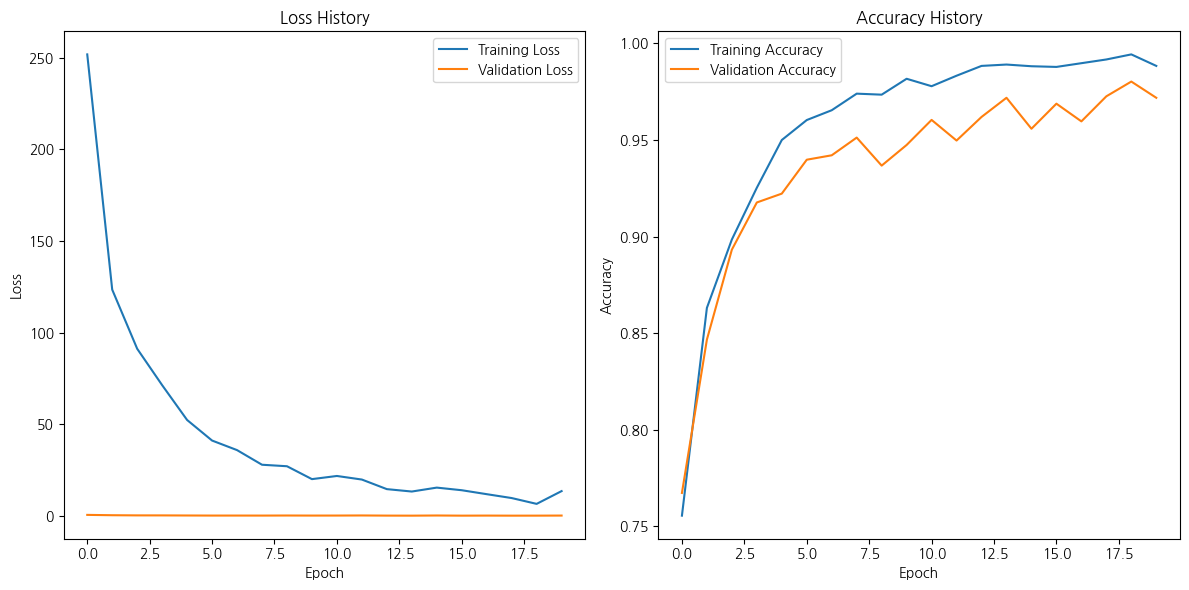

In [12]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()